### Database examples

This is a worked example of the use of several NoSQL databases (MongoDB, ChromaDB, and Neo4j) for the chapter on Data Management. 

The question that we will ask in this analysis is: Can the biological similarity between two traits (estimated using pathway enrichment of genome-wide association study [GWAS] data) be estimated from the semantic similarity of published abstracts that mention that trait?

In [ ]:
import pandas as pd
import pymongo
import dotenv
import os
from neo4j import GraphDatabase
from chromadb import PersistentClient
from tqdm.notebook import tqdm
from pathlib import Path
from database import (
    setup_mongo_collection, 
    get_chromadb_collection,
    get_neo4j_session
)
from BetterCodeBetterScience.database_example_funcs import (
    get_exploded_gwas_data,
    import_geneset_annotations_by_trait, 
    get_trait_info_from_ols,
    annotate_geneset_annotations_by_trait,
    get_pathway_info_by_trait,
    compute_phenotype_similarities,
    compute_text_similarities
)
from BetterCodeBetterScience.database import get_mongo_client
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext rpy2.ipython

dotenv.load_dotenv()
datadir = Path(os.getenv('DATA_DIR', '../../data'))

### Step 1: load gwas-phenotype associations

We will use a database of GWAS results from [EBI](https://www.ebi.ac.uk/gwas/docs/file-downloads). 

These might seem perfect for a relational database, but they are not quite ready, because one of the columns of interest (`SNP_GENE_IDS`, which maps the snp to one or more genes) maps to multiple genes in some cases, and thus violates the First Normal Form. We could fix this by exploding the column:

In [ ]:
gwas_data = get_exploded_gwas_data()

found data for 4329 unique PUBMEDIDs


This is now ready to import to a relational database. However, for this example we will use a document store (MongoDB) to store the records, since it I find it much easier to work with.  We will first generate a collection that links trait identifiers to the gene sets that have been identified for that trait in GWAS.  

In [ ]:
import_geneset_annotations_by_trait(gwas_data)

Pinged your deployment. You successfully connected to MongoDB!
Number of documents in geneset_annotations_by_trait: 1878


100%|██████████| 3047/3047 [00:17<00:00, 174.38it/s]


### Functional annotation of gene sets

Each trait is associated with one or more genes based on the GWAS data.  However, given that genes work together in networks, we would like to estimate the similarity using the biological products or pathways that are associated with each set of genes, rather the similarity of the specific genes associated with each phenotype.  We will perform this annotation using the [g:Profiler](https://biit.cs.ut.ee/gprofiler/gost) tool from ELIXIR, which comes with a handy [Python package](https://pypi.org/project/gprofiler-official/).   This tool returns a set of pathways that are statistically enriched for each gene set.


In [4]:
annotate_geneset_annotations_by_trait()

Pinged your deployment. You successfully connected to MongoDB!
Number of documents in geneset_annotations_by_trait: 3047


  0%|          | 3/1169 [00:05<34:50,  1.79s/it]


KeyboardInterrupt: 

### Get trait info

Next we will create a database collection that stores information about each of the traits in the GWAS dataset, using the EBI OLS API. In particular, we want to obtain a list of synonyms for the name of each trait, which we will use in our literature search.

In [7]:
get_trait_info_from_ols()

Pinged your deployment. You successfully connected to MongoDB!
Number of documents in trait_info_by_trait: 1617
Pinged your deployment. You successfully connected to MongoDB!
Number of documents in geneset_annotations_by_trait: 3047
Found 982 un-annotated trait URIs.


  1%|          | 8/982 [00:10<20:20,  1.25s/it]


KeyboardInterrupt: 

## ???

Next we want to create another database collection that will map from trait identifiers to the specific pathways that were obtained in the earlier step based on the associated gene sets.

In [ ]:
get_pathway_info_by_trait()

SyntaxError: incomplete input (2233363149.py, line 2)

### Graph database example

Next we want to compute the similarity of traits in terms of the biological processes that they are associated with.  We will do this using the Neo4j graph database, which has a set of data analysis methods that will allow us to easily compute the required similarity metric.  

First we need to add our trait and pathway information to the Neo4j database.  We start by adding the traits as nodes, and then add the pathways along with their links to each trait.  

In [ ]:
# Assuming Neo4j is running locally with default credentials
# For production, use environment variables or secure config
# browse db at http://localhost:7474/browser/



build_neo4j_graph()

Number of documents in geneset_annotations_by_trait: 3047
Number of documents in pathways: 6073


In [ ]:
similarity_result_df = compute_phenotype_similarities()

Received notification from DBMS server: <GqlStatusObject gql_status='01N01', status_description='warn: feature deprecated with replacement. id is deprecated. It is replaced by elementId or consider using an application-generated id.', position=<SummaryInputPosition line=6, column=15, offset=203>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 203, 'line': 6, 'column': 15}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: "\n        CALL gds.nodeSimilarity.stream('phenotype-pathway-graph')\n        YIELD node1, node2, similarity\n        WITH node1, node2, similarity\n        MATCH (p1:Phenotype), (p2:Phenotype)\n        WHERE id(p1) = node1 AND id(p2) = node2\n            AND COUNT { (p1)-[:MAPPED_TO]->(:Pathway) } > 1\n        

### Get pubmed abstracts for each trait using trait name and synomyms

Next we want to obtain some abstracts related to each trait, which we will use to compute semantic similarity between traits.  We will download abstracts from Pubmed, using the trait name and any synonyms that were obtained in the previous step.  First we will submit each query (using the `Biopython.Entrez` module) and obtain the first 100 pubmed IDs that are returned for the query.

In [14]:
get_pmids_for_traits()


Pinged your deployment. You successfully connected to MongoDB!
Number of documents in trait_info_by_trait: 1625


Searching PubMed:   0%|          | 0/1625 [00:00<?, ?it/s]

PMIDs already exist for response to radiation, skipping...
PMIDs already exist for response to xenobiotic stimulus, skipping...
PMIDs already exist for response to lithium ion, skipping...
PMIDs already exist for response to gemcitabine, skipping...
PMIDs already exist for response to antidepressant, skipping...
PMIDs already exist for response to anticonvulsant, skipping...
PMIDs already exist for response to antibiotic, skipping...
PMIDs already exist for response to antineoplastic agent, skipping...
PMIDs already exist for response to carboplatin, skipping...
PMIDs already exist for response to bronchodilator, skipping...
PMIDs already exist for response to fenofibrate, skipping...
PMIDs already exist for response to ribavirin, skipping...
PMIDs already exist for response to cyclophosphamide, skipping...
PMIDs already exist for response to docetaxel trihydrate, skipping...
PMIDs already exist for response to doxorubicin, skipping...


Now we create a separate database collection to store the retrieved abstracts from Pubmed.

In [ ]:
fetch_and_store_pubmed_abstracts()

### Add documents to chromadb vector db

We want to use the documents downloaded from Pubmed to compute the semantic similarity between traits.  This is a good application for a *vector database*, which can ingest documents, embed them into a vector space, and then perform similarity computations between documents based on their vector embeddings.  We will use ChromaDB which is a popular open-source vector database. 

In [2]:
# add to chromadb vector db
add_pubmed_abstracts_to_chromadb()

NameError: name 'add_pubmed_abstracts_to_chromadb' is not defined

Now use chromadb to get average text similarity for 

In [ ]:

text_similarity_df = compute_text_similarities(similarity_result_df)


Number of documents in pmids_by_trait: 1625


Text(0.5, 1.0, 'Pathway Similarity vs Text Similarity (r=0.23)')

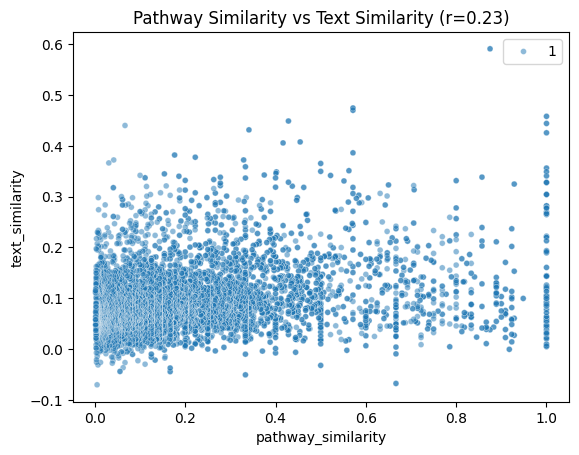

In [ ]:
sns.scatterplot(
    data=text_similarity_df,
    x='pathway_similarity',
    y='text_similarity',
    alpha=0.5,
    size=1
)
plt.title(f'Pathway Similarity vs Text Similarity (r={text_similarity_df["pathway_similarity"].corr(text_similarity_df["text_similarity"]):.2f})')

In [150]:
%%R -i results_df

if (!requireNamespace("lme4", quietly = TRUE)) {
    install.packages("lme4")
}
library(lme4)
model <- lmer(text_similarity ~ pathway_similarity + (1 | phenotype1) + (1 | phenotype2), data = results_df)
summary(model)  

Linear mixed model fit by REML ['lmerMod']
Formula: text_similarity ~ pathway_similarity + (1 | phenotype1) + (1 |  
    phenotype2)
   Data: results_df

REML criterion at convergence: -19572

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9570 -0.5258 -0.0791  0.4008  9.0908 

Random effects:
 Groups     Name        Variance Std.Dev.
 phenotype1 (Intercept) 0.001315 0.03626 
 phenotype2 (Intercept) 0.001069 0.03270 
 Residual               0.002004 0.04476 
Number of obs: 6621, groups:  phenotype1, 982; phenotype2, 898

Fixed effects:
                   Estimate Std. Error t value
(Intercept)        0.081344   0.002184   37.25
pathway_similarity 0.074715   0.004652   16.06

Correlation of Fixed Effects:
            (Intr)
pthwy_smlrt -0.590
